<font size='5'>Loss of Auto-correlation during Re-sampling</font>

This notebook demonstrates how sampling from the posterior of the variational inference model does not preserve auto-correlation. Since the transition matrix,

P = \begin{bmatrix}
p_{1,1} & p_{1,2} & p_{1,3} & p_{1,4} & p_{1,5} \\
p_{2,1} & p_{2,2} & p_{2,3} & p_{2,4} & p_{2,5} \\
p_{3,1} & p_{3,2} & p_{3,3} & p_{3,4} & p_{3,5} \\
p_{4,1} & p_{4,2} & p_{4,3} & p_{4,4} & p_{4,5} \\
p_{5,1} & p_{5,2} & p_{5,3} & p_{5,4} & p_{5,5} \\
\end{bmatrix}

is defined as the probability of transitioning from any given latent state to another, and these transition probabilities are based on the probability across the whole dataset, and not weighed by the most recently observed data (which would be the case for serially, auto-correlated data). 

In [48]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured by the latent state. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [49]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [50]:
m6 = pd.read_csv('.././data/assets_m6.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data; use of the rolling mean log price increases serial correlation in the post-processed data. 

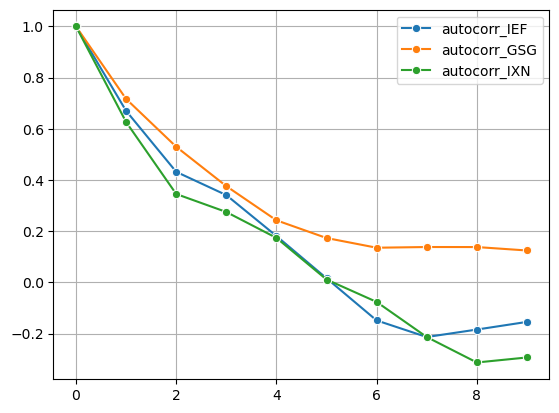

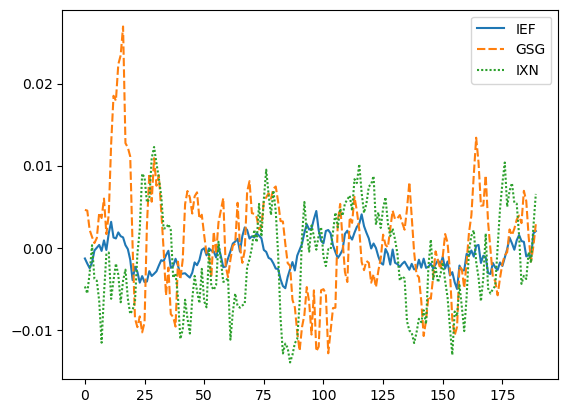

In [51]:
m6_subset = m6_assets.copy().apply(np.log).rolling(9).mean().apply(np.diff)
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF']
autocorr_df['decay_GSG'] = m6_subset['GSG']
autocorr_df['decay_IXN'] = m6_subset['IXN']
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(0, 10)), label='autocorr_IEF', marker='o')
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(0, 10)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(0, 10)), label='autocorr_IXN', marker='o')
plt.grid(True)
plt.show()

sns.lineplot(data=m6_subset)
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. Then, sample len(m6_subset) points from the variational model. This sampling should respect the empirical transition matrix of the data. After re-sampling, the call to the decay_func() shows that auto-correlation drops off sharply as compared to the original data. 

In [52]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')

In [59]:
dpgmm_model.fit(m6_subset)

states = []
samples = []

# Sample len(m6_subset) from the generative model 
for s in range(len(m6_subset)):
    sample, y = dpgmm_model.sample(1)
    states.append(y[0])
    samples.append(sample[0])

# Create dataframe
df = pd.DataFrame()
df['0']=[ s[0] for s in samples ]
df['1']=[ s[1] for s in samples ]
df['2']=[ s[2] for s in samples ]

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

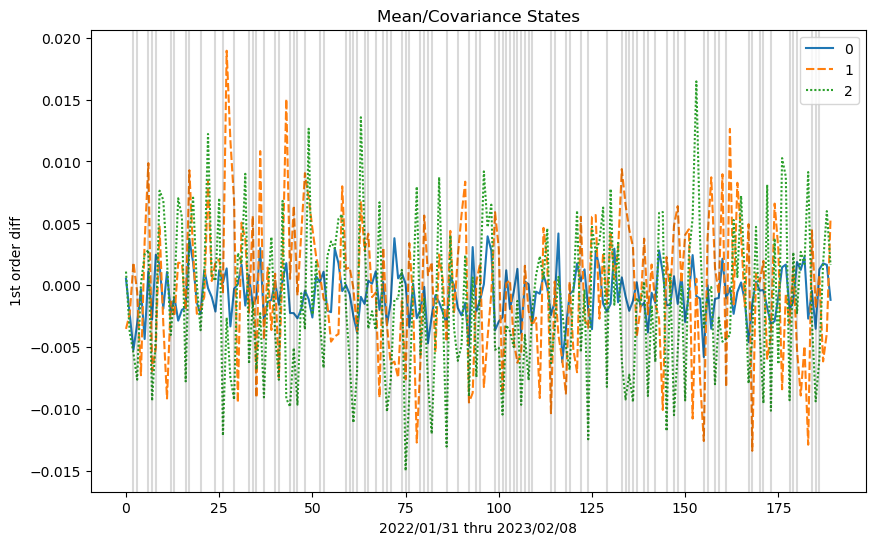

In [69]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(data=df, ax=ax)

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Mean/Covariance States')
ax.set_ylabel('1st order diff')
ax.set_xlabel(f'2022/01/31 thru 2023/02/08')
plt.show()

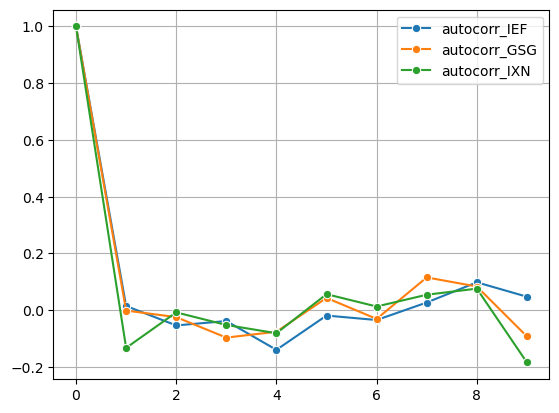

In [71]:
sns.lineplot(data=decay_func(df['0'], range(0, 10)), label='autocorr_IEF', marker='o')
sns.lineplot(data=decay_func(df['1'], range(0, 10)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(df['2'], range(0, 10)), label='autocorr_IXN', marker='o')
plt.grid(True)
plt.show()